## __기본옵션__

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import os, glob
import numpy as np
import pandas as pd
from PIL import Image
import pickle
import cv2
import matplotlib.pyplot as plt
import warnings 
from time import time
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization,Add,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LeakyReLU, ReLU, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
dh_dir = "/content/drive/My Drive/KPMG/classifier"
os.chdir(dh_dir)

In [ ]:
os.getcwd()

'/content/drive/My Drive/KPMG/classifier'

## __데이터 불러오기__

In [ ]:
# pickle파일 read
with open("/content/drive/My Drive/KPMG/classifier/pickle/batang.pkl","rb") as pk:
  batang_pk = pickle.load(pk)
with open("/content/drive/My Drive/KPMG/classifier/pickle/dotum.pkl","rb") as pk:
  dotum_pk = pickle.load(pk)
with open("/content/drive/My Drive/KPMG/classifier/pickle/gothic.pkl","rb") as pk:
  gothic_pk = pickle.load(pk)
with open("/content/drive/My Drive/KPMG/classifier/pickle/myeongjo.pkl","rb") as pk:
  myeongjo_pk = pickle.load(pk)


In [ ]:
# 전체 이미지 array 저장해놓은 것
# image_all = batang_pk+dotum_pk+gothic_pk+myeongjo_pk
batang_pk=np.array(batang_pk)
dotum_pk=np.array(dotum_pk)
gothic_pk=np.array(gothic_pk)
myeongjo_pk=np.array(myeongjo_pk)

In [ ]:
# seed설정
np.random.seed(0)

# 인덱스 만들어 주고 순서를 랜덤으로 바꾸어 인덱스를 출력해주는 함수
def make_index_permutation(font_pk):
  result=np.random.permutation(np.arange(len(font_pk)))
  return result


In [ ]:
batang_index=make_index_permutation(batang_pk)
dotum_index=make_index_permutation(dotum_pk)
gothic_index=make_index_permutation(gothic_pk)
myeongjo_index=make_index_permutation(myeongjo_pk)

In [ ]:
import math

## font_index를 slicing으로 split 해주고 리스트에 추가해주는 함수

def data_split_merge(split_cnt,font_index):
  result=[]
  for i in range(0,split_cnt):
    result.append(font_index[round((i*(len(font_index))/split_cnt)):round((i+1)*(len(font_index))/split_cnt)])
  return result


In [ ]:
split_cnt = 8

batang_index_list=data_split_merge(split_cnt,batang_index)
dotum_index_list=data_split_merge(split_cnt,dotum_index)
gothic_index_list=data_split_merge(split_cnt,gothic_index)
myeongjo_index_list=data_split_merge(split_cnt,myeongjo_index)


In [ ]:
# 원하는 갯수로 train data로 나눠주는 함수

def make_train_data(split_cnt,font_pk,font_index_list):
  result=[]
  for i in range(split_cnt):
    result.append(font_pk[font_index_list[i]])
  return result

In [ ]:
batang_train=make_train_data(split_cnt,batang_pk,batang_index_list)
dotum_train=make_train_data(split_cnt,dotum_pk,dotum_index_list)
gothic_train=make_train_data(split_cnt,gothic_pk,gothic_index_list)
myeongjo_train=make_train_data(split_cnt,myeongjo_pk,myeongjo_index_list)

total_train=[]
for i in range(split_cnt):
  total_train.append(batang_train[i].tolist()+dotum_train[i].tolist()+gothic_train[i].tolist()+myeongjo_train[i].tolist())

In [ ]:
total_df_list=[]

for i in range(split_cnt):
  batang_df= pd.DataFrame({'image':batang_train[i], 'category':0})
  dotum_df = pd.DataFrame({'image':dotum_train[i], 'category':1})
  gothic_df = pd.DataFrame({'image':gothic_train[i], 'category':2})
  myeongjo_df = pd.DataFrame({'image':myeongjo_train[i], 'category':3})
  total_df=pd.concat([batang_df,dotum_df,gothic_df,myeongjo_df])
  total_df.reset_index(drop=True, inplace=True)
  total_df_list.append(total_df)

In [ ]:
X_list=[]

def make_X_list(total_train_data):
  img=[]
  for i in range(len(total_train_data)):
    img.append(cv2.resize(total_train_data[i],(64,64)))
  return img


In [ ]:
for i in range(split_cnt):
  X_list.append(make_X_list(total_train[i]))

## __모델링 (VGG16)__

### Train, Validation Split

In [ ]:
# categories = data['category'].unique()
# nb_classes = len(categories)
# class_name=['batang', 'dotum','gothic','myeongjo']

def make_train_XY(X,total_df_list,idx):
  return X_list[idx],np.array(total_df_list[idx]['category'])

#### 아래 train_XY안에 있는 idx를 0~split_cnt-1까지 바꿔주면서 넣어주기만 하면 됨

X,Y=make_train_XY(X_list,total_df_list,0)
X=np.array(X)

In [ ]:
X.shape

(13806, 64, 64, 3)

In [ ]:
Y.shape

(13806,)

In [ ]:
# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

### VGG16 모델

In [6]:
# vgg16 불러오기
pre_trained_vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
pre_trained_vgg.trainable = False
# pre_trained_vgg.summary()

58892288/58889256 [==============================] - 1s 0us/step


In [7]:
model = keras.models.Sequential()
model.add(pre_trained_vgg)
model.add(keras.layers.Flatten()) # 2048
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 17,339,716
Trainable params: 2,625,028
Non-trainable params: 14,714,688
_________________________________________________________________


#### optimizer 변경

##### adam

In [ ]:
# vgg16 불러오기
pre_trained_vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
pre_trained_vgg.trainable = False
# pre_trained_vgg.summary()

model = keras.models.Sequential()
model.add(pre_trained_vgg)
model.add(keras.layers.Flatten()) # 2048
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Epoch 1/20
36/36 [==============================] - 21s 589ms/step - loss: 5.0071 - accuracy: 0.5511 - val_loss: 0.6300 - val_accuracy: 0.6919
Epoch 2/20
36/36 [==============================] - 15s 426ms/step - loss: 0.5174 - accuracy: 0.7566 - val_loss: 0.4883 - val_accuracy: 0.7635
Epoch 3/20
36/36 [==============================] - 15s 427ms/step - loss: 0.3908 - accuracy: 0.8303 - val_loss: 0.4042 - val_accuracy: 0.8164
Epoch 4/20
36/36 [==============================] - 15s 427ms/step - loss: 0.3100 - accuracy: 0.8749 - val_loss: 0.3665 - val_accuracy: 0.8388
Epoch 5/20
36/36 [==============================] - 15s 427ms/step - loss: 0.2495 - accuracy: 0.9014 - val_loss: 0.3339 - val_accuracy: 0.8572
Epoch 6/20
36/36 [==============================] - 15s 428ms/step - loss: 0.2014 - accuracy: 0.9255 - val_loss: 0.3404 - val_accuracy: 0.8493
Epoch 7/20
36/36 [==============================] - 15s 427ms/step - loss: 0.1640 - accuracy: 0.9414 - val_loss: 0.3080 - val_accuracy: 0.8699

##### nadam

In [ ]:
# vgg16 불러오기
pre_trained_vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
pre_trained_vgg.trainable = False
# pre_trained_vgg.summary()

model = keras.models.Sequential()
model.add(pre_trained_vgg)
model.add(keras.layers.Flatten()) # 2048
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Epoch 1/20
18/18 [==============================] - 2s 129ms/step - loss: 7.9543 - accuracy: 0.4705 - val_loss: 1.1481 - val_accuracy: 0.6342
Epoch 2/20
18/18 [==============================] - 2s 119ms/step - loss: 0.8525 - accuracy: 0.6686 - val_loss: 0.5528 - val_accuracy: 0.7483
Epoch 3/20
18/18 [==============================] - 2s 118ms/step - loss: 0.5236 - accuracy: 0.7604 - val_loss: 0.7985 - val_accuracy: 0.6564
Epoch 4/20
18/18 [==============================] - 2s 120ms/step - loss: 0.3762 - accuracy: 0.8379 - val_loss: 0.5266 - val_accuracy: 0.7664
Epoch 5/20
18/18 [==============================] - 2s 119ms/step - loss: 0.3029 - accuracy: 0.8758 - val_loss: 0.5436 - val_accuracy: 0.7501
Epoch 6/20
18/18 [==============================] - 2s 119ms/step - loss: 0.3048 - accuracy: 0.8602 - val_loss: 0.3894 - val_accuracy: 0.8248
Epoch 7/20
18/18 [==============================] - 2s 120ms/step - loss: 0.1793 - accuracy: 0.9397 - val_loss: 0.3932 - val_accuracy: 0.8284
Epoch 

##### SGD

In [ ]:
# vgg16 불러오기
pre_trained_vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
pre_trained_vgg.trainable = False
# pre_trained_vgg.summary()

model = keras.models.Sequential()
model.add(pre_trained_vgg)
model.add(keras.layers.Flatten()) # 2048
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Epoch 1/20
18/18 [==============================] - 2s 129ms/step - loss: 12.8992 - accuracy: 0.4188 - val_loss: 0.8845 - val_accuracy: 0.5731
Epoch 2/20
18/18 [==============================] - 2s 118ms/step - loss: 0.7735 - accuracy: 0.6239 - val_loss: 0.7459 - val_accuracy: 0.6365
Epoch 3/20
18/18 [==============================] - 2s 118ms/step - loss: 0.6511 - accuracy: 0.6919 - val_loss: 0.6350 - val_accuracy: 0.7057
Epoch 4/20
18/18 [==============================] - 2s 118ms/step - loss: 0.6051 - accuracy: 0.7135 - val_loss: 0.6161 - val_accuracy: 0.7048
Epoch 5/20
18/18 [==============================] - 2s 117ms/step - loss: 0.5739 - accuracy: 0.7262 - val_loss: 0.6737 - val_accuracy: 0.6555
Epoch 6/20
18/18 [==============================] - 2s 117ms/step - loss: 0.5167 - accuracy: 0.7640 - val_loss: 0.5844 - val_accuracy: 0.7279
Epoch 7/20
18/18 [==============================] - 2s 118ms/step - loss: 0.5115 - accuracy: 0.7591 - val_loss: 0.5454 - val_accuracy: 0.7383
Epoch

##### Adadelta

In [ ]:
# vgg16 불러오기
pre_trained_vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
pre_trained_vgg.trainable = False
# pre_trained_vgg.summary()

model = keras.models.Sequential()
model.add(pre_trained_vgg)
model.add(keras.layers.Flatten()) # 2048
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Epoch 1/20
18/18 [==============================] - 2s 129ms/step - loss: 7.0601 - accuracy: 0.2796 - val_loss: 6.4501 - val_accuracy: 0.2734
Epoch 2/20
18/18 [==============================] - 2s 117ms/step - loss: 5.8685 - accuracy: 0.2901 - val_loss: 5.4303 - val_accuracy: 0.2852
Epoch 3/20
18/18 [==============================] - 2s 117ms/step - loss: 4.9981 - accuracy: 0.2989 - val_loss: 4.6995 - val_accuracy: 0.2938
Epoch 4/20
18/18 [==============================] - 2s 118ms/step - loss: 4.3831 - accuracy: 0.3074 - val_loss: 4.1871 - val_accuracy: 0.3060
Epoch 5/20
18/18 [==============================] - 2s 118ms/step - loss: 3.9510 - accuracy: 0.3312 - val_loss: 3.8262 - val_accuracy: 0.3332
Epoch 6/20
18/18 [==============================] - 2s 118ms/step - loss: 3.6401 - accuracy: 0.3560 - val_loss: 3.5585 - val_accuracy: 0.3499
Epoch 7/20
18/18 [==============================] - 2s 118ms/step - loss: 3.4031 - accuracy: 0.3642 - val_loss: 3.3491 - val_accuracy: 0.3567
Epoch 

##### Rmsprop

In [ ]:
# vgg16 불러오기
pre_trained_vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
pre_trained_vgg.trainable = False
# pre_trained_vgg.summary()

model = keras.models.Sequential()
model.add(pre_trained_vgg)
model.add(keras.layers.Flatten()) # 2048
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Epoch 1/20
18/18 [==============================] - 2s 130ms/step - loss: 19.6504 - accuracy: 0.4646 - val_loss: 1.3389 - val_accuracy: 0.5645
Epoch 2/20
18/18 [==============================] - 2s 118ms/step - loss: 0.9707 - accuracy: 0.6229 - val_loss: 0.7216 - val_accuracy: 0.6709
Epoch 3/20
18/18 [==============================] - 2s 117ms/step - loss: 0.8654 - accuracy: 0.6599 - val_loss: 0.5248 - val_accuracy: 0.7610
Epoch 4/20
18/18 [==============================] - 2s 118ms/step - loss: 0.6270 - accuracy: 0.7229 - val_loss: 0.6754 - val_accuracy: 0.7021
Epoch 5/20
18/18 [==============================] - 2s 118ms/step - loss: 0.6218 - accuracy: 0.7339 - val_loss: 0.8513 - val_accuracy: 0.6347
Epoch 6/20
18/18 [==============================] - 2s 117ms/step - loss: 0.5745 - accuracy: 0.7530 - val_loss: 0.9340 - val_accuracy: 0.6569
Epoch 7/20
18/18 [==============================] - 2s 118ms/step - loss: 0.3817 - accuracy: 0.8302 - val_loss: 0.7231 - val_accuracy: 0.7130
Epoch

##### adagrad

In [ ]:
# vgg16 불러오기
pre_trained_vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
pre_trained_vgg.trainable = False
# pre_trained_vgg.summary()

model = keras.models.Sequential()
model.add(pre_trained_vgg)
model.add(keras.layers.Flatten()) # 2048
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adagrad", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Epoch 1/20
18/18 [==============================] - 2s 129ms/step - loss: 5.5241 - accuracy: 0.4876 - val_loss: 1.5854 - val_accuracy: 0.5695
Epoch 2/20
18/18 [==============================] - 2s 117ms/step - loss: 0.9039 - accuracy: 0.6676 - val_loss: 0.6897 - val_accuracy: 0.7076
Epoch 3/20
18/18 [==============================] - 2s 118ms/step - loss: 0.5916 - accuracy: 0.7460 - val_loss: 0.6371 - val_accuracy: 0.7220
Epoch 4/20
18/18 [==============================] - 2s 118ms/step - loss: 0.5306 - accuracy: 0.7698 - val_loss: 0.5820 - val_accuracy: 0.7392
Epoch 5/20
18/18 [==============================] - 2s 118ms/step - loss: 0.4135 - accuracy: 0.8195 - val_loss: 0.5804 - val_accuracy: 0.7406
Epoch 6/20
18/18 [==============================] - 2s 117ms/step - loss: 0.4175 - accuracy: 0.8117 - val_loss: 0.5628 - val_accuracy: 0.7537
Epoch 7/20
18/18 [==============================] - 2s 117ms/step - loss: 0.3281 - accuracy: 0.8647 - val_loss: 0.4998 - val_accuracy: 0.7909
Epoch 

모델저장 에러 참고   
https://mylifemystudy.tistory.com/69

#### Training

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

def Time(model, train_X,train_Y, batch_size, n_epoch):

  training_start_time = time()
  trained_model = model.fit(train_X, train_Y,
                            batch_size=batch_size, epochs=n_epoch,
                            validation_split = 0.2)
  training_end_time = time()
  print("Training time finished.\n%d epochs in %12.2f" % (n_epoch,
                                                          training_end_time - training_start_time))
  return trained_model

In [ ]:
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

Epoch 1/20
18/18 [==============================] - 28s 2s/step - loss: 325966.1250 - accuracy: 0.2856 - val_loss: 1.3826 - val_accuracy: 0.3214
Epoch 2/20
18/18 [==============================] - 18s 993ms/step - loss: 1.3800 - accuracy: 0.3185 - val_loss: 1.3763 - val_accuracy: 0.3214
Epoch 3/20
18/18 [==============================] - 18s 1000ms/step - loss: 1.3753 - accuracy: 0.3185 - val_loss: 1.3732 - val_accuracy: 0.3214
Epoch 4/20
18/18 [==============================] - 18s 1s/step - loss: 1.3742 - accuracy: 0.3185 - val_loss: 1.3730 - val_accuracy: 0.3214
Epoch 5/20
18/18 [==============================] - 18s 1s/step - loss: 1.3738 - accuracy: 0.3185 - val_loss: 1.3729 - val_accuracy: 0.3214
Epoch 6/20
18/18 [==============================] - 18s 1s/step - loss: 1.3741 - accuracy: 0.3185 - val_loss: 1.3731 - val_accuracy: 0.3214
Epoch 7/20
18/18 [==============================] - 18s 1s/step - loss: 1.3740 - accuracy: 0.3185 - val_loss: 1.3730 - val_accuracy: 0.3214
Epoch 8/

##### 1번째 학습

In [ ]:
# 모델저장
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/fc_model_1.json", "w") as json_file:
  json_file.write(model_json)

# 가중치 저장
model.save_weights("/content/drive/My Drive/KPMG/classifier/model/fc_weight_1.h5")

Using TensorFlow backend.


In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/fc_model_1.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/fc_weight_1.h5'
loaded_model.load_weights(weight)

##### 2번째 학습

In [ ]:
X,Y=make_train_XY(X_list,total_df_list,1)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

Epoch 1/20
18/18 [==============================] - 4s 197ms/step - loss: 2.0951 - accuracy: 0.8685 - val_loss: 0.1872 - val_accuracy: 0.9484
Epoch 2/20
18/18 [==============================] - 2s 117ms/step - loss: 0.1244 - accuracy: 0.9606 - val_loss: 0.1114 - val_accuracy: 0.9642
Epoch 3/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1373 - accuracy: 0.9581 - val_loss: 0.1348 - val_accuracy: 0.9602
Epoch 4/20
18/18 [==============================] - 2s 117ms/step - loss: 0.5478 - accuracy: 0.9204 - val_loss: 0.1196 - val_accuracy: 0.9642
Epoch 5/20
18/18 [==============================] - 2s 117ms/step - loss: 0.1581 - accuracy: 0.9602 - val_loss: 0.1732 - val_accuracy: 0.9230
Epoch 6/20
18/18 [==============================] - 2s 116ms/step - loss: 0.0559 - accuracy: 0.9808 - val_loss: 0.2481 - val_accuracy: 0.9411
Epoch 7/20
18/18 [==============================] - 2s 117ms/step - loss: 0.2526 - accuracy: 0.9471 - val_loss: 0.1082 - val_accuracy: 0.9701
Epoch 

In [ ]:
# 모델저장
from keras.models import model_from_json
model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/fc_model_2.json", "w") as json_file:
  json_file.write(model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/fc_weight_2.h5")

from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/fc_model_2.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/fc_weight_2.h5'
loaded_model.load_weights(weight)

##### 3번째 학습

In [ ]:
X,Y=make_train_XY(X_list,total_df_list,2)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

Epoch 1/20
18/18 [==============================] - 4s 196ms/step - loss: 1.9369 - accuracy: 0.8361 - val_loss: 0.3079 - val_accuracy: 0.9068
Epoch 2/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1767 - accuracy: 0.9388 - val_loss: 0.4426 - val_accuracy: 0.8566
Epoch 3/20
18/18 [==============================] - 2s 115ms/step - loss: 0.2501 - accuracy: 0.9176 - val_loss: 0.3046 - val_accuracy: 0.8959
Epoch 4/20
18/18 [==============================] - 2s 115ms/step - loss: 0.4346 - accuracy: 0.8985 - val_loss: 0.3354 - val_accuracy: 0.8860
Epoch 5/20
18/18 [==============================] - 2s 115ms/step - loss: 0.0915 - accuracy: 0.9656 - val_loss: 0.3785 - val_accuracy: 0.9018
Epoch 6/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1838 - accuracy: 0.9364 - val_loss: 0.2603 - val_accuracy: 0.9122
Epoch 7/20
18/18 [==============================] - 2s 115ms/step - loss: 0.3808 - accuracy: 0.9221 - val_loss: 0.2554 - val_accuracy: 0.9158
Epoch 

In [ ]:
# 모델저장
from keras.models import model_from_json
model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/fc_model_3.json", "w") as json_file:
  json_file.write(model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/fc_weight_3.h5")

from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/fc_model_3.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/fc_weight_3.h5'
loaded_model.load_weights(weight)

##### 4번째 학습

In [ ]:
X,Y=make_train_XY(X_list,total_df_list,3)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

Epoch 1/20
18/18 [==============================] - 2s 125ms/step - loss: 1.1034 - accuracy: 0.8587 - val_loss: 0.1893 - val_accuracy: 0.9357
Epoch 2/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1467 - accuracy: 0.9482 - val_loss: 0.2496 - val_accuracy: 0.9316
Epoch 3/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1730 - accuracy: 0.9375 - val_loss: 0.1658 - val_accuracy: 0.9470
Epoch 4/20
18/18 [==============================] - 2s 116ms/step - loss: 0.2588 - accuracy: 0.9265 - val_loss: 0.1820 - val_accuracy: 0.9402
Epoch 5/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1520 - accuracy: 0.9564 - val_loss: 0.2359 - val_accuracy: 0.9262
Epoch 6/20
18/18 [==============================] - 2s 116ms/step - loss: 0.0725 - accuracy: 0.9751 - val_loss: 0.7300 - val_accuracy: 0.8656
Epoch 7/20
18/18 [==============================] - 2s 116ms/step - loss: 0.2466 - accuracy: 0.9483 - val_loss: 0.1670 - val_accuracy: 0.9561
Epoch 

In [ ]:
# 모델저장
from keras.models import model_from_json
model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/fc_model_4.json", "w") as json_file:
  json_file.write(model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/fc_weight_4.h5")

from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/fc_model_4.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/fc_weight_4.h5'
loaded_model.load_weights(weight)

##### 5번째 학습

In [ ]:
X,Y=make_train_XY(X_list,total_df_list,4)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

Epoch 1/20
18/18 [==============================] - 2s 124ms/step - loss: 1.3726 - accuracy: 0.8690 - val_loss: 0.2108 - val_accuracy: 0.9407
Epoch 2/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1514 - accuracy: 0.9480 - val_loss: 0.1927 - val_accuracy: 0.9411
Epoch 3/20
18/18 [==============================] - 2s 115ms/step - loss: 0.1329 - accuracy: 0.9544 - val_loss: 0.4382 - val_accuracy: 0.9031
Epoch 4/20
18/18 [==============================] - 2s 116ms/step - loss: 0.6109 - accuracy: 0.9140 - val_loss: 0.2170 - val_accuracy: 0.9389
Epoch 5/20
18/18 [==============================] - 2s 116ms/step - loss: 0.0512 - accuracy: 0.9812 - val_loss: 0.2212 - val_accuracy: 0.9434
Epoch 6/20
18/18 [==============================] - 2s 115ms/step - loss: 0.1198 - accuracy: 0.9637 - val_loss: 0.2382 - val_accuracy: 0.9316
Epoch 7/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1994 - accuracy: 0.9503 - val_loss: 1.0142 - val_accuracy: 0.8339
Epoch 

In [ ]:
# 모델저장
from keras.models import model_from_json
model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/fc_model_5.json", "w") as json_file:
  json_file.write(model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/fc_weight_5.h5")

from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/fc_model_5.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/fc_weight_5.h5'
loaded_model.load_weights(weight)

##### 6번째 학습

In [ ]:
X,Y=make_train_XY(X_list,total_df_list,5)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

Epoch 1/20
18/18 [==============================] - 2s 124ms/step - loss: 0.8281 - accuracy: 0.9009 - val_loss: 0.2221 - val_accuracy: 0.9312
Epoch 2/20
18/18 [==============================] - 2s 116ms/step - loss: 0.2338 - accuracy: 0.9406 - val_loss: 0.8808 - val_accuracy: 0.8385
Epoch 3/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1368 - accuracy: 0.9567 - val_loss: 0.1903 - val_accuracy: 0.9434
Epoch 4/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1557 - accuracy: 0.9576 - val_loss: 0.4354 - val_accuracy: 0.9059
Epoch 5/20
18/18 [==============================] - 2s 116ms/step - loss: 0.0908 - accuracy: 0.9687 - val_loss: 0.2236 - val_accuracy: 0.9448
Epoch 6/20
18/18 [==============================] - 2s 115ms/step - loss: 0.1098 - accuracy: 0.9682 - val_loss: 0.3631 - val_accuracy: 0.9348
Epoch 7/20
18/18 [==============================] - 2s 115ms/step - loss: 0.3787 - accuracy: 0.9366 - val_loss: 0.1207 - val_accuracy: 0.9593
Epoch 

In [ ]:
# 모델저장
from keras.models import model_from_json
model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/fc_model_6.json", "w") as json_file:
  json_file.write(model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/fc_weight_6.h5")

from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/fc_model_6.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/fc_weight_6.h5'
loaded_model.load_weights(weight)

##### 7번째 학습

In [ ]:
X,Y=make_train_XY(X_list,total_df_list,6)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

Epoch 1/20
18/18 [==============================] - 2s 124ms/step - loss: 1.0820 - accuracy: 0.8994 - val_loss: 0.2075 - val_accuracy: 0.9498
Epoch 2/20
18/18 [==============================] - 2s 116ms/step - loss: 0.0955 - accuracy: 0.9660 - val_loss: 0.2836 - val_accuracy: 0.9498
Epoch 3/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1817 - accuracy: 0.9543 - val_loss: 0.4687 - val_accuracy: 0.9004
Epoch 4/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1804 - accuracy: 0.9526 - val_loss: 0.2026 - val_accuracy: 0.9430
Epoch 5/20
18/18 [==============================] - 2s 116ms/step - loss: 0.0461 - accuracy: 0.9814 - val_loss: 0.2321 - val_accuracy: 0.9547
Epoch 6/20
18/18 [==============================] - 2s 116ms/step - loss: 0.2137 - accuracy: 0.9554 - val_loss: 0.2176 - val_accuracy: 0.9448
Epoch 7/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1537 - accuracy: 0.9719 - val_loss: 0.6633 - val_accuracy: 0.8782
Epoch 

In [ ]:
# 모델저장
from keras.models import model_from_json
model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/fc_model_7.json", "w") as json_file:
  json_file.write(model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/fc_weight_7.h5")

from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/fc_model_7.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/fc_weight_7.h5'
loaded_model.load_weights(weight)

##### 8번째 학습

In [ ]:
X,Y=make_train_XY(X_list,total_df_list,7)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

Epoch 1/20
18/18 [==============================] - 2s 124ms/step - loss: 1.0134 - accuracy: 0.9073 - val_loss: 0.2422 - val_accuracy: 0.9425
Epoch 2/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1094 - accuracy: 0.9663 - val_loss: 0.1916 - val_accuracy: 0.9525
Epoch 3/20
18/18 [==============================] - 2s 116ms/step - loss: 0.1659 - accuracy: 0.9557 - val_loss: 0.2327 - val_accuracy: 0.9353
Epoch 4/20
18/18 [==============================] - 2s 117ms/step - loss: 0.1403 - accuracy: 0.9602 - val_loss: 0.3182 - val_accuracy: 0.9307
Epoch 5/20
18/18 [==============================] - 2s 115ms/step - loss: 0.2408 - accuracy: 0.9559 - val_loss: 0.2583 - val_accuracy: 0.9316
Epoch 6/20
18/18 [==============================] - 2s 116ms/step - loss: 0.0390 - accuracy: 0.9854 - val_loss: 0.2336 - val_accuracy: 0.9574
Epoch 7/20
18/18 [==============================] - 2s 116ms/step - loss: 0.2630 - accuracy: 0.9597 - val_loss: 0.1654 - val_accuracy: 0.9629
Epoch 

In [ ]:
# 모델저장
from keras.models import model_from_json
model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/fc_model_8.json", "w") as json_file:
  json_file.write(model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/fc_weight_8.h5")

from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/fc_model_8.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/fc_weight_8.h5'
loaded_model.load_weights(weight)

### 평가

In [ ]:
# 모델, weight 로드
from tensorflow.compat.v2.keras.models import model_from_json
json_file = open("/content/drive/My Drive/KPMG/classifier/model/fc_model_8.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/fc_weight_8.h5'
loaded_model.load_weights(weight)

In [ ]:
# 숫자 변경하면서 좋은거 골라보기
X,Y=make_train_XY(X_list,total_df_list,1)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

In [ ]:
y_pred=loaded_model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
from sklearn.preprocessing import OneHotEncoder

# y의 실제값, 예측값 one hot encoding해주는 함수

def make_onehot(vector):
  enc=OneHotEncoder()
  vector=vector.reshape(-1,1)
  enc.fit(vector)
  return enc.transform(vector).toarray()

y_pred_onehot=make_onehot(y_pred)
y_test_onehot=make_onehot(y_test)


In [ ]:
y_pred_onehot=make_onehot(y_pred)
y_test_onehot=make_onehot(y_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       646
           1       0.80      0.99      0.88       646
           2       0.99      0.80      0.88       881
           3       0.98      0.96      0.97       588

    accuracy                           0.92      2761
   macro avg       0.93      0.93      0.93      2761
weighted avg       0.93      0.92      0.92      2761



In [ ]:
import itertools

# confusion matrix 생성 함수
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
    

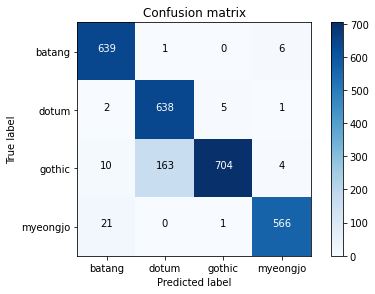

In [ ]:
# Predict the values from the validation dataset
y_pred=loaded_model.predict(X_test)
# Convert predictions classes to one hot vectors
y_pred = np.argmax(y_pred, axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test,y_pred)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['batang','dotum','gothic','myeongjo'])

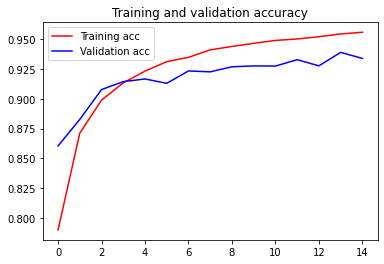

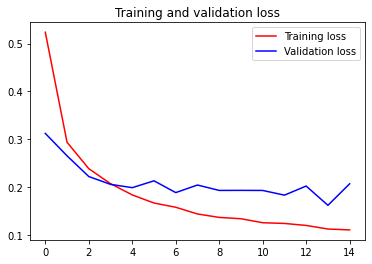

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
score = additional_model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

1014/1014 [==============================] - 11s 11ms/step - loss: 0.2065 - accuracy: 0.9339
[0.20653964579105377, 0.9338883757591248]
loss :  0.20653964579105377
accuracy :  0.9338883757591248


In [ ]:
y_true = y_test
y_pred = np.argmax(additional_model.predict(X_test), axis=-1)
# true_test = np.array(data['category'])

print(classification_report(y_true, y_pred, target_names=['바탕','돋움','고딕','명조']))

              precision    recall  f1-score   support

          바탕       0.87      0.97      0.92      7050
          돋움       0.92      0.85      0.88      7050
          고딕       0.96      0.95      0.95     10575
          명조       0.97      0.96      0.97      7755

    accuracy                           0.93     32430
   macro avg       0.93      0.93      0.93     32430
weighted avg       0.94      0.93      0.93     32430



In [ ]:
# 0: 바탕 / 1: 돋움 / 2: 고딕 / 3: 명조
true_y = pd.Series(y_true)
pred_y = pd.Series(y_pred)

print("<            CROSSTAB             >")
print(pd.crosstab(true_y, pred_y, rownames=['True'], colnames=['Predicted']))
print(" ")
print("=============================================")
print(" ")
print("<          CONFUSION MATRIX           >")
confusion = pd.DataFrame(confusion_matrix(true_y,pred_y),columns=class_name, index=class_name)
print(confusion)

<            CROSSTAB             >
Predicted     0     1      2     3
True                              
0          6804     1     14   231
1           691  5995    363     1
2            20   522  10032     1
3           266     1     33  7455
 
 
<          CONFUSION MATRIX           >
          batang  dotum  gothic  myeongjo
batang      6804      1      14       231
dotum        691   5995     363         1
gothic        20    522   10032         1
myeongjo     266      1      33      7455


## __testing__

### Unclassified fonts

In [ ]:
# 테스트 이미지 불러오기
# 64x64로 사이즈 맞춰주기

with open("/content/drive/My Drive/classifier/pickle/test.pkl","rb") as pk:
  test_pk = pickle.load(pk)

test_img = []
for i in range(len(test_pk)):
  test_img.append(cv2.resize(test_pk[i], (64,64)))

test_img = np.array(test_img)

In [ ]:
test_img.shape

(9400, 64, 64, 3)

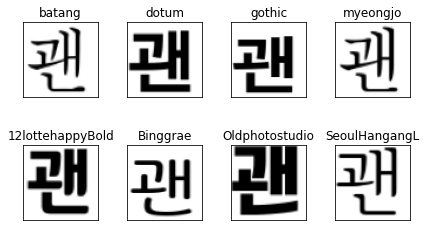

In [ ]:
num =[2, 2+2350*10, 2+2350*23, 2+2350*36]
name = class_name
fontlist=[2,2352,4702,7052]
fontname=["12lottehappyBold", "Binggrae", "Oldphotostudio", "SeoulHangangL"]


def font_plot(idx):
  plt.subplot(241+idx)
  plt.imshow(img[num[idx]])
  plt.title(name[idx])
  plt.gca().xaxis.set_major_locator(plt.NullLocator())
  plt.gca().yaxis.set_major_locator(plt.NullLocator())
  
def newfont_plot(idx):
  plt.subplot(245+idx)
  plt.imshow(test_img[fontlist[idx]])
  plt.title(fontname[idx])
  plt.gca().xaxis.set_major_locator(plt.NullLocator())
  plt.gca().yaxis.set_major_locator(plt.NullLocator())
  plt.tight_layout()

for i in range(0,4):
  font_plot(i)
  newfont_plot(i)

plt.show()

In [ ]:
# 예측
name =['바탕','돋움','고딕','명조']
lotte_pred = additional_model.predict(test_img)
result = [np.argmax(value) for value in lotte_pred]
print("12lottehappyBold폰트 '괜'의 카테고리 : ", name[result[2]])
print("Binggrae폰트 '괜'의 카테고리 : ", name[result[2+2350]])
print("Oldphotostudio폰트 '괜'의 카테고리 : ", name[result[2+2350*2]])
print("SeoulHangangL폰트 '괜'의 카테고리 : ", name[result[2+2350*3]])

12lottehappyBold폰트 '괜'의 카테고리 :  고딕
Binggrae폰트 '괜'의 카테고리 :  고딕
Oldphotostudio폰트 '괜'의 카테고리 :  고딕
SeoulHangangL폰트 '괜'의 카테고리 :  고딕


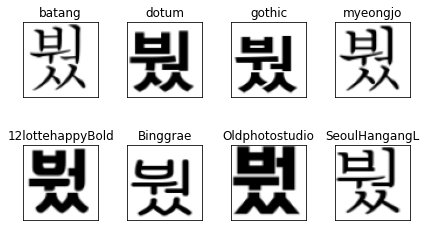

In [ ]:
num =[4, 4+2350*10, 4+2350*23, 4+2350*36]
fontlist=[4,2354,4704,7054]

for i in range(0,4):
  font_plot(i)
  newfont_plot(i)

plt.show()

In [ ]:
# 예측
name =['바탕','돋움','고딕','명조']
lotte_pred = additional_model.predict(test_img)
result = [np.argmax(value) for value in lotte_pred]
print("12lottehappyBold폰트 '붰'의 카테고리 : ", name[result[4]])
print("Binggrae폰트 '붰'의 카테고리 : ", name[result[4+2350]])
print("Oldphotostudio폰트 '붰'의 카테고리 : ", name[result[4+2350*2]])
print("SeoulHangangL폰트 '붰'의 카테고리 : ", name[result[4+2350*3]])

12lottehappyBold폰트 '붰'의 카테고리 :  돋움
Binggrae폰트 '붰'의 카테고리 :  돋움
Oldphotostudio폰트 '붰'의 카테고리 :  고딕
SeoulHangangL폰트 '붰'의 카테고리 :  바탕


In [ ]:
# 음절, 폰트에 따라 분류를 다르게 하는 것 같음
print("새로운 폰트가 들어왔을 때,")
print("바탕으로 분류한 개수 : ", result.count(0))
print("돋움으로 분류한 개수 : ", result.count(1))
print("고딕으로 분류한 개수 : ", result.count(2))
print("명조으로 분류한 개수 : ", result.count(3))

새로운 폰트가 들어왔을 때,
바탕으로 분류한 개수 :  943
돋움으로 분류한 개수 :  878
고딕으로 분류한 개수 :  6330
명조으로 분류한 개수 :  1249


### detecting image test

In [ ]:
detect_img = cv2.imread("/content/drive/My Drive/classifier/detect_1.png")

In [ ]:
# detect_img = preprocess_input(detect_img)
# detect_img = detect_img.astype('float32')/255.0


In [ ]:
detect_img.shape

(18, 15, 3)

In [ ]:
detect_img = cv2.resize(detect_img,(64,64))
detect_img = np.reshape(detect_img, (1,64,64,3))

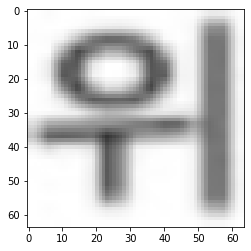

In [ ]:
plt.imshow(detect_img)

In [ ]:
name = ['바탕','돋움','고딕','명조']
pred = loaded_model.predict(detect_img)
result = [np.argmax(value) for value in pred]
print("Image's font is : ", name[result[0]])

ValueError: ignored